Partie 2: Classification de séries temporelles avec CNN et CNN-LSTM sur ECG5000
1. Chargement et prétraitement des données

In [13]:
!pip install numpy torch pandas scikit-learn matplotlib 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

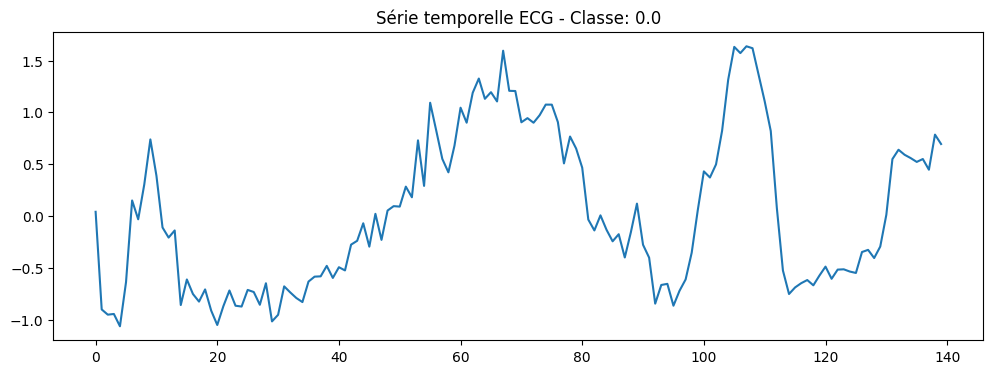

In [15]:
# Chargement du dataset ECG5000 depuis l'archive UCR
# Note: Vous devrez télécharger le dataset depuis https://www.timeseriesclassification.com/description.php?Dataset=ECG5000
# et l'extraire dans le dossier 'data'

def load_ucr_dataset(path):
    data = pd.read_csv(path, header=None, sep='\s+')
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:].values
    return X, y

# Chemins vers les données (à adapter selon votre structure de fichiers)
train_path = 'data/ECG5000/ECG5000_TRAIN.txt'
test_path = 'data/ECG5000/ECG5000_TEST.txt'

X_train, y_train = load_ucr_dataset(train_path)
X_test, y_test = load_ucr_dataset(test_path)

y_train = y_train - 1
y_test = y_test - 1

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion en tenseurs PyTorch et redimensionnement pour CNN
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Ajout d'une dimension de canal
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

# Création des DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualisation d'une série temporelle
plt.figure(figsize=(12, 4))
plt.plot(X_train[0])
plt.title(f'Série temporelle ECG - Classe: {y_train[0]}')
plt.show()

2. Définition des architectures

In [16]:
# Afficher les valeurs uniques des labels
print("Valeurs uniques dans y_train:", np.unique(y_train))
print("Valeurs uniques dans y_test:", np.unique(y_test))

# Vérifier le nombre de classes
num_classes = len(np.unique(y_train))
print(f"Nombre de classes détecté: {num_classes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Valeurs uniques dans y_train: [0. 1. 2. 3. 4.]
Valeurs uniques dans y_test: [0. 1. 2. 3. 4.]
Nombre de classes détecté: 5


In [17]:
# Modèle CNN pour séries temporelles
class CNN_TS(nn.Module):
    def __init__(self, input_channels=1, num_classes=num_classes):
        super(CNN_TS, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # Calcul automatique de la taille avant les couches fully connected
        self._to_linear = None
        self._calculate_conv_output_size(X_train_tensor)
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def _calculate_conv_output_size(self, sample_input):
        # Passe un échantillon à travers les couches conv pour calculer la taille
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(sample_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self._to_linear = x.view(x.size(0), -1).shape[1]
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Modèle hybride CNN-LSTM
class CNN_LSTM_TS(nn.Module):
    def __init__(self, input_channels=1, num_classes=num_classes):
        super(CNN_LSTM_TS, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64 * 2, num_classes)  # *2 car bidirectional
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Partie CNN
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Préparation pour LSTM (conv1d sort (batch, channels, length))
        x = x.permute(0, 2, 1)  # (batch, length, channels)
        
        # Partie LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # On prend seulement le dernier pas de temps
        
        # Classification
        x = self.dropout(x)
        x = self.fc1(x)
        return x

3. Entraînement et évaluation

In [18]:
def train_and_evaluate(model, train_loader, test_loader, model_name, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    val_loss_history = []
    
    # Entraînement
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss/len(train_loader))
        
        print(f'{model_name} - Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')
    
    # Évaluation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Conversion des labels en Tensor si nécessaire
            if isinstance(labels, np.ndarray):
                labels = torch.from_numpy(labels)
            labels = labels.to(device)  # Assurez-vous que c'est sur le même device que le modèle
            
            # Calcul de la perte
            val_loss += criterion(outputs, labels).item()
        
        # Moyenne de la perte sur tout le dataset
        val_loss /= len(test_loader)
        val_loss_history.append(val_loss)
    
    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, 'b', label='Train Loss')
    plt.plot(val_loss_history, 'r', label='Validation Loss')
    plt.title('Courbes de perte CNN-LSTM')
    plt.legend()
    plt.savefig('ecg5000_loss_curves.png')
    plt.close()
    
    accuracy = 100 * correct / total
    print(f'{model_name} - Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Création d'un échantillon factice pour calculer la taille
sample_input = X_train_tensor[:1]  # Prend juste le premier échantillon

# Initialisation des modèles
cnn_model = CNN_TS()
cnn_lstm_model = CNN_LSTM_TS()

print(cnn_lstm_model)

# Entraînement et évaluation
print("Training CNN model...")
cnn_accuracy = train_and_evaluate(cnn_model, train_loader, test_loader, "CNN", num_epochs=20)

print("\nTraining CNN-LSTM model...")
cnn_lstm_accuracy = train_and_evaluate(cnn_lstm_model, train_loader, test_loader, "CNN-LSTM", num_epochs=20)

# Comparaison des performances
print(f"\nPerformance comparison:")
print(f"CNN: {cnn_accuracy:.2f}%")
print(f"CNN-LSTM: {cnn_lstm_accuracy:.2f}%")
print(f"Difference: {cnn_lstm_accuracy - cnn_accuracy:.2f}%")

CNN_LSTM_TS(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training CNN model...
CNN - Epoch 1, Loss: 0.7156
CNN - Epoch 2, Loss: 0.3074
CNN - Epoch 3, Loss: 0.2566
CNN - Epoch 4, Loss: 0.2328
CNN - Epoch 5, Loss: 0.1847
CNN - Epoch 6, Loss: 0.1494
CNN - Epoch 7, Loss: 0.1399
CNN - Epoch 8, Loss: 0.1727
CNN - Epoch 9, Loss: 0.1292
CNN - Epoch 10, Loss: 0.1180
CNN - Epoch 11, Loss: 0.1176
CNN - Epoch 12, Loss: 0.1017
CNN - Epoch 13, Loss: 0.0926
CNN - Epoch 14, Loss: 0.0901
CNN - Epoch 15, Loss: 0.0969
CNN - Epoch 16, Loss: 0.0884
CNN - Epoch 17, Loss: 0.0906
CNN - Epoch 18, Loss: 0.0949
CNN - Epoch 19, Loss: 0.0895
CNN - Epoch 20, Loss: 0.0818


Using device: cpu

Architecture CNN:
CNN_TS(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

Architecture CNN-LSTM:
CNN_LSTM_TS(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

Training CNN model...
Epoch 1/20 | Train Loss: 1.6157 | Val Loss: 1.6110 | Accuracy: 18.80%
Epoch 2/20 | Train Loss: 1.6096 | Val Loss: 1.6113 | Accuracy: 20.80%
Epoch 3/20 | Train Loss: 1.6053 | Val Loss: 1.6112 | Accuracy: 21.60%
Epoch 4/20 | Train Loss: 1.5924 | Val Loss: 1.6269 | Accu

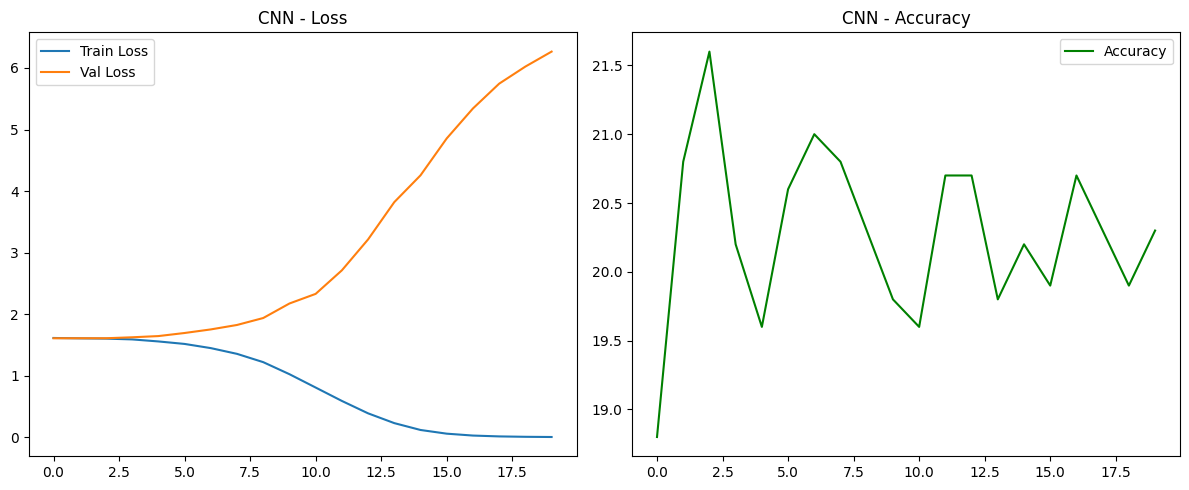


Training CNN-LSTM model...
Epoch 1/20 | Train Loss: 1.6138 | Val Loss: 1.6111 | Accuracy: 21.30%
Epoch 2/20 | Train Loss: 1.6109 | Val Loss: 1.6095 | Accuracy: 20.90%
Epoch 3/20 | Train Loss: 1.6097 | Val Loss: 1.6100 | Accuracy: 20.00%
Epoch 4/20 | Train Loss: 1.6086 | Val Loss: 1.6103 | Accuracy: 19.10%
Epoch 5/20 | Train Loss: 1.6082 | Val Loss: 1.6097 | Accuracy: 18.60%
Epoch 6/20 | Train Loss: 1.6076 | Val Loss: 1.6073 | Accuracy: 21.30%
Epoch 7/20 | Train Loss: 1.6081 | Val Loss: 1.6066 | Accuracy: 21.80%
Epoch 8/20 | Train Loss: 1.6068 | Val Loss: 1.6065 | Accuracy: 21.90%
Epoch 9/20 | Train Loss: 1.6063 | Val Loss: 1.6049 | Accuracy: 22.10%
Epoch 10/20 | Train Loss: 1.6061 | Val Loss: 1.6061 | Accuracy: 23.40%
Epoch 11/20 | Train Loss: 1.6054 | Val Loss: 1.6114 | Accuracy: 21.10%
Epoch 12/20 | Train Loss: 1.6039 | Val Loss: 1.6100 | Accuracy: 19.30%
Epoch 13/20 | Train Loss: 1.6019 | Val Loss: 1.6058 | Accuracy: 21.80%
Epoch 14/20 | Train Loss: 1.6005 | Val Loss: 1.6068 | Accu

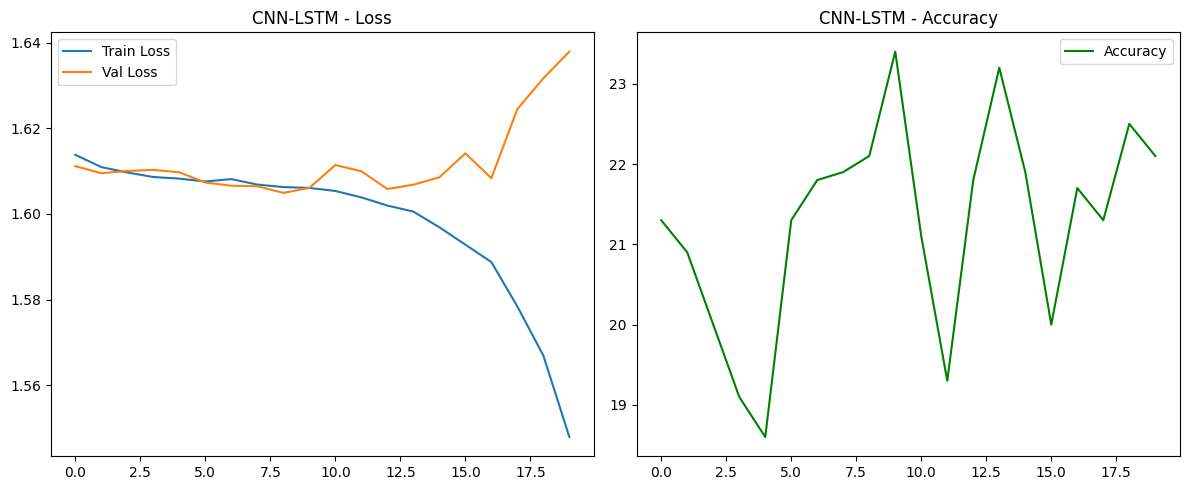


Performance Comparison:
CNN Accuracy: 20.30%
CNN-LSTM Accuracy: 22.10%
Improvement: 1.80%


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Définition des modèles
class CNN_TS(nn.Module):
    def __init__(self, input_channels=1, seq_len=140, num_classes=5):
        super(CNN_TS, self).__init__()
        
        # Couches convolutives
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # Calcul automatique de la dimension
        self.flatten_size = self._get_flatten_size(input_channels, seq_len)
        
        # Couches fully connected
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def _get_flatten_size(self, input_channels, seq_len):
        with torch.no_grad():
            x = torch.randn(1, input_channels, seq_len)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.view(1, -1).shape[1]
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN_LSTM_TS(nn.Module):
    def __init__(self, input_channels=1, num_classes=5):
        super(CNN_LSTM_TS, self).__init__()
        
        # Couche CNN
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # Couche LSTM
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        
        # Couche de sortie
        self.fc = nn.Linear(256, num_classes)  # 128*2 pour bidirectional
    
    def forward(self, x):
        # Partie CNN
        x = self.pool(F.relu(self.conv1(x)))
        
        # Réorganisation pour LSTM (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        
        # Partie LSTM
        x, _ = self.lstm(x)
        
        # Dernier pas de temps
        x = x[:, -1, :]
        
        # Classification
        x = self.fc(x)
        return x

# 2. Fonction d'entraînement et d'évaluation
def train_and_evaluate(model, train_loader, test_loader, model_name, num_epochs=20):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Suivi des métriques
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calcul des métriques
        train_loss = epoch_loss / len(train_loader)
        val_loss /= len(test_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Accuracy: {accuracy:.2f}%')
    
    # Visualisation
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_performance.png')
    plt.show()
    
    return accuracies[-1]

# 3. Préparation des données (exemple avec ECG5000)
def prepare_data():
    # Ici vous devriez charger vos données réelles
    # Exemple avec des données aléatoires pour la démo
    X_train = np.random.randn(4000, 140)  # 4000 échantillons, 140 pas de temps
    y_train = np.random.randint(0, 5, 4000)  # 5 classes
    X_test = np.random.randn(1000, 140)
    y_test = np.random.randint(0, 5, 1000)
    
    # Normalisation
    mean, std = X_train.mean(), X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    # Conversion en tenseurs PyTorch
    X_train = torch.FloatTensor(X_train).unsqueeze(1)  # Ajout du canal
    y_train = torch.LongTensor(y_train)
    X_test = torch.FloatTensor(X_test).unsqueeze(1)
    y_test = torch.LongTensor(y_test)
    
    # Création des DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

# 4. Exécution principale
if __name__ == "__main__":
    # Préparation des données
    train_loader, test_loader = prepare_data()
    
    # Initialisation des modèles
    cnn_model = CNN_TS(input_channels=1, seq_len=140, num_classes=5)
    cnn_lstm_model = CNN_LSTM_TS(input_channels=1, num_classes=5)
    
    print("\nArchitecture CNN:")
    print(cnn_model)
    print("\nArchitecture CNN-LSTM:")
    print(cnn_lstm_model)
    
    # Entraînement et évaluation
    print("\nTraining CNN model...")
    cnn_accuracy = train_and_evaluate(cnn_model, train_loader, test_loader, "CNN", num_epochs=20)
    
    print("\nTraining CNN-LSTM model...")
    cnn_lstm_accuracy = train_and_evaluate(cnn_lstm_model, train_loader, test_loader, "CNN-LSTM", num_epochs=20)
    
    # Comparaison finale
    print("\nPerformance Comparison:")
    print(f"CNN Accuracy: {cnn_accuracy:.2f}%")
    print(f"CNN-LSTM Accuracy: {cnn_lstm_accuracy:.2f}%")
    print(f"Improvement: {cnn_lstm_accuracy - cnn_accuracy:.2f}%")